# CH14 Deep Computer Vision Using Convolutional Neural Networks

In [44]:
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [45]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Convolutional Layers

In [46]:
from sklearn.datasets import load_sample_images

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

print(images.shape)

(2, 70, 120, 3)


In [47]:
tf.reduce_max(images[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [48]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',activation='relu')
fmaps = conv_layer(images)
print(fmaps.shape)

(2, 70, 120, 32)


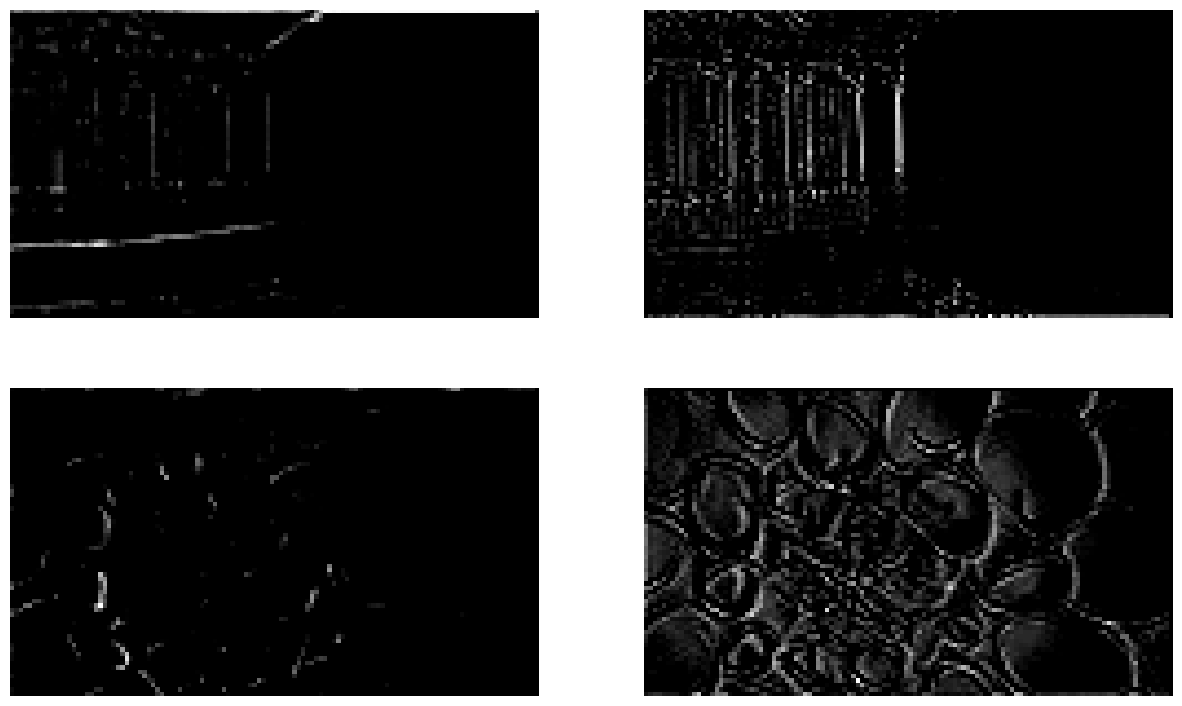

In [49]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [50]:
# using strides

conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [51]:
kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape

((7, 7, 3, 32), (32,))

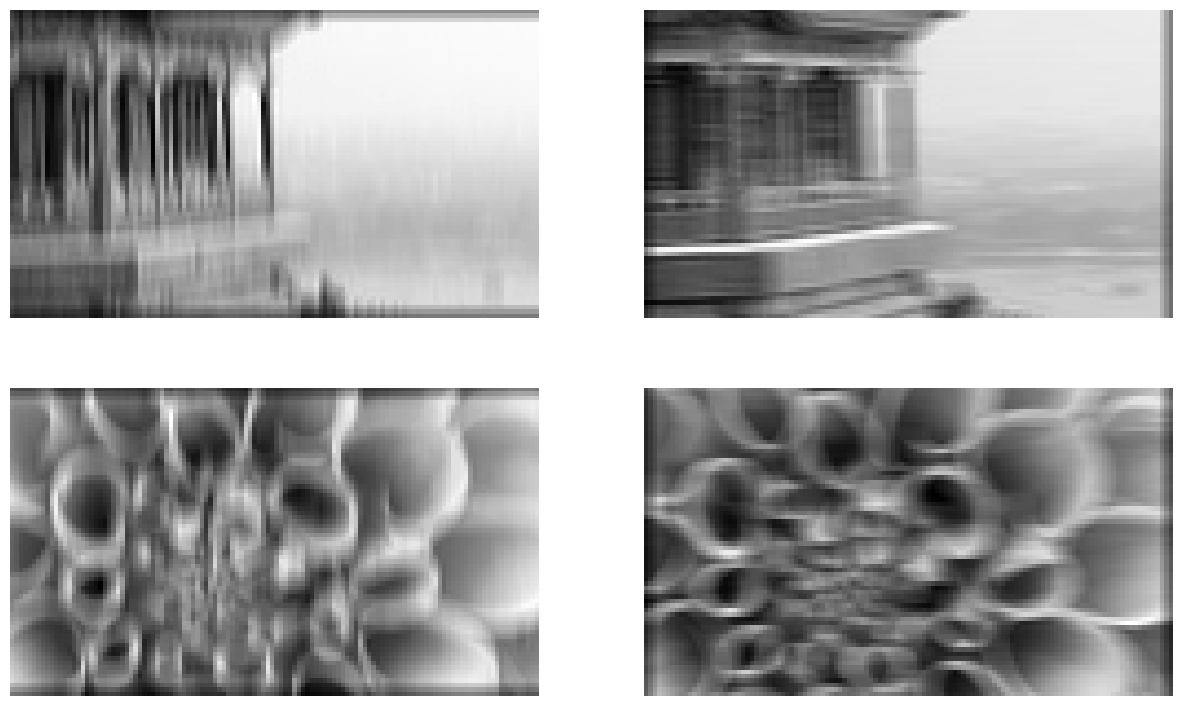

In [52]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

### Pooling Layers

In [53]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [54]:
output = max_pool(images)

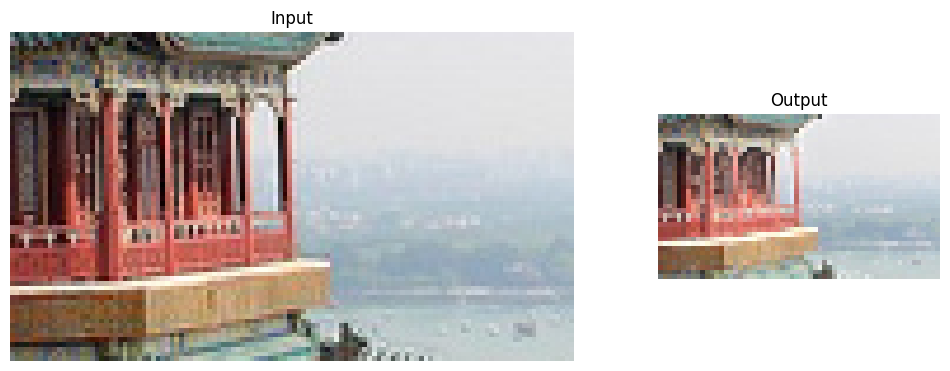

In [55]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [56]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

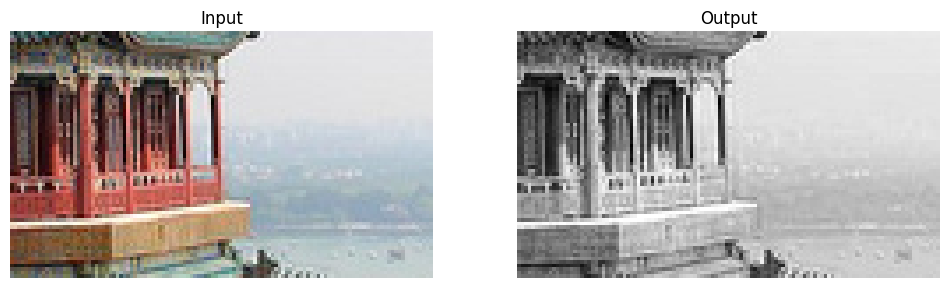

In [57]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

In [58]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
# the same as
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

----

## CNN Architecture

In [59]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [60]:
X_train[0].shape, y_train[0]

((28, 28, 1), 9)

In [61]:
from functools import partial

tf.random.set_seed(42)
defualt_conv2d = partial(tf.keras.layers.Conv2D,kernel_size=3,strides=1,
                                        padding='same',activation='relu',kernel_initializer='he_normal')


model = tf.keras.models.Sequential([
  defualt_conv2d(filters=64, kernel_size=7, input_shape=[28,28,1]),
  tf.keras.layers.MaxPool2D(),
  defualt_conv2d(filters=128),
  defualt_conv2d(filters=128),
  tf.keras.layers.MaxPool2D(),
  defualt_conv2d(filters=256),
  defualt_conv2d(filters=256),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation='relu',kernel_initializer='he_normal'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=64, activation='relu',kernel_initializer='he_normal'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=10, activation='softmax')

 ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [63]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid),batch_size=256)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.3420 - loss: 1.8433 - val_accuracy: 0.7842 - val_loss: 0.6463
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.6681 - loss: 0.8776 - val_accuracy: 0.8510 - val_loss: 0.4428
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7749 - loss: 0.6374 - val_accuracy: 0.8684 - val_loss: 0.3961
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8116 - loss: 0.5307 - val_accuracy: 0.8824 - val_loss: 0.3581
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8416 - loss: 0.4526 - val_accuracy: 0.8896 - val_loss: 0.3229
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8648 - loss: 0.3990 - val_accuracy: 0.9018 - val_loss: 0.2865
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8833 - loss: 0.3445 - val_accuracy: 0.8996 - val_loss: 0.2913
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8960 - loss: 0.3050 - val_

In [64]:
score = model.evaluate(X_test, y_test)
score

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9106 - loss: 0.2862


[0.2748308777809143, 0.9093999862670898]

In [65]:
X_new = X_test[:10]
y_pred = model.predict(X_new)
np.argmax(tf.nn.softmax(y_pred),-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])